/tmp/ipykernel_11443/2627013543.py:64: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal
/tmp/ipykernel_11443/2627013543.py:73: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal


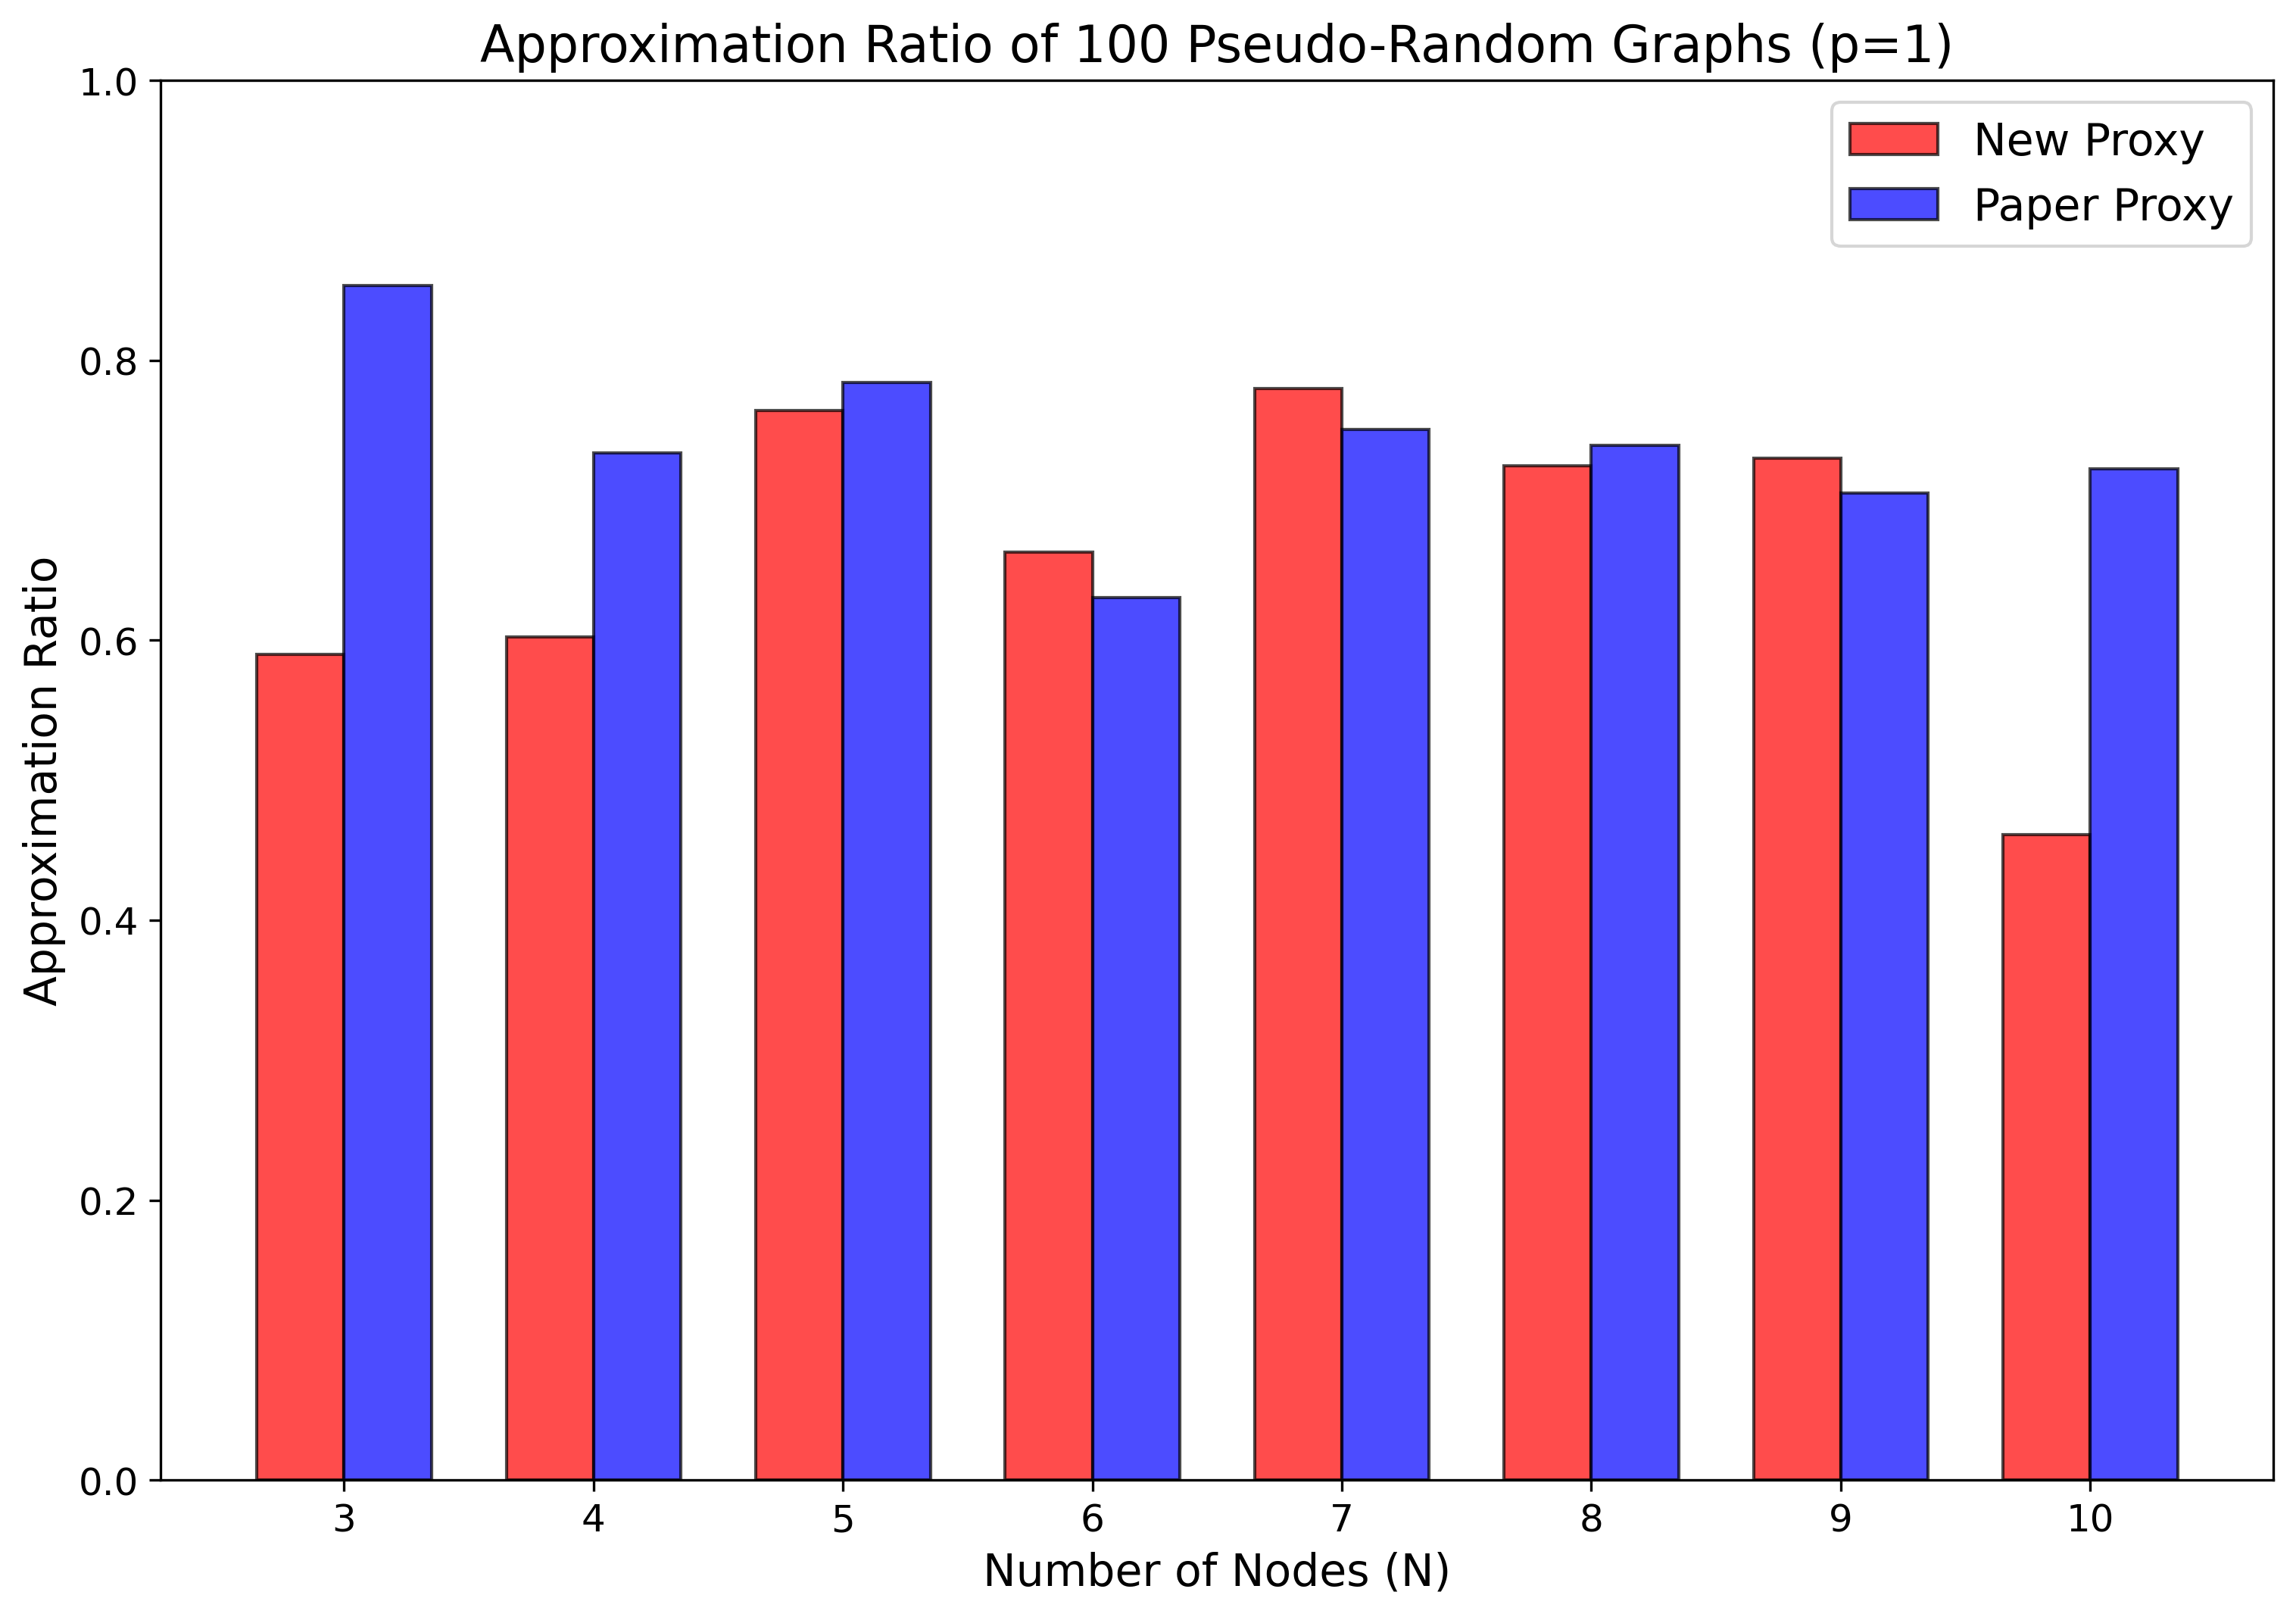

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_expectation, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp
import os  # データ保存に必要

# QAOAの層数
p = 1

# seedの設定
seed = 0

# 各Nの近似比率を格納するリスト（各Nに対して10回の平均を格納）
approx_ratios_new_proxy = []
approx_ratios_paper_proxy = []

def erdos_reyni(num_verts: int, num_edges: int, seed: int | None = None) -> nx.Graph:
    # num_verts: グラフの頂点の数
    # num_edges: グラフのエッジの数
    # seed: 乱数生成のシード（省略可能）

    G = nx.complete_graph(num_verts)

    if (seed is not None):
        np.random.seed(seed)

    edges = np.array(G.edges())

    indices = np.random.choice(a=len(edges), size=len(edges) - num_edges, replace=False)

    for index in indices:
        G.remove_edge(edges[index][0], edges[index][1])

    return G

# 試行回数
T = 100

# 保存先ディレクトリを指定
save_dir = f"data_for_graphs_Approx_Raito_P={p}_T={T}"
os.makedirs(save_dir, exist_ok=True)

# Nを5から10まで変化させて計算
for N in range(3, 11):
    for i in range(T):
        
        approx_ratios_new_proxy_i = []
        approx_ratios_paper_proxy_i = []

        G = nx.erdos_renyi_graph(N, 0.5)
        ising_model = mc.get_maxcut_terms(G)
        sim = get_simulator(N, ising_model)

        init_gamma, init_beta = np.full((2, p), 0.1)

        result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]
        expectation = get_expectation(N, ising_model, gamma, beta)
        max_cost_diagonal = max(sim.get_cost_diagonal())
        approx_ratio = expectation / max_cost_diagonal
        approx_ratios_new_proxy_i.append(approx_ratio)
        np.save(f"{save_dir}/data_for_approx_ratio_new_proxy_N={N}_G{i}.npy", approx_ratio)

        result = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]
        expectation = get_expectation(N, ising_model, gamma, beta)
        max_cost_diagonal = max(sim.get_cost_diagonal())
        approx_ratio = expectation / max_cost_diagonal
        approx_ratios_paper_proxy_i.append(approx_ratio)
        np.save(f"{save_dir}/data_for_approx_ratio_paper_proxy_N={N}_G{i}.npy", approx_ratio)

    approx_ratios_new_proxy.append(np.mean(approx_ratios_new_proxy_i))
    approx_ratios_paper_proxy.append(np.mean(approx_ratios_paper_proxy_i))


# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 11)  #x軸のインデックス


# グラフのサイズと解像度の設定（figsizeとdpiを調整）
plt.figure(figsize=(12, 8), dpi=300)

# 新しいプロキシの棒グラフ（枠を黒色に設定）
plt.bar(index - bar_width / 2, approx_ratios_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy', edgecolor='black')

# 論文プロキシの棒グラフ（枠を黒色に設定）
plt.bar(index + bar_width / 2, approx_ratios_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy', edgecolor='black')


# グラフの設定
plt.xlabel('Number of Nodes (N)', fontsize=14)  # 横軸のラベル
plt.ylabel('Approximation Ratio', fontsize=14)  # 縦軸のラベル
plt.title(f'Approximation Ratio of {T} Pseudo-Random Graphs (p={p})', fontsize=16)  # 題名
plt.xticks(index, fontsize=12)  # x軸の目盛りのサイズ
plt.yticks(fontsize=12)  # y軸の目盛りのサイズ
plt.ylim([0, 1])  # 縦軸の範囲を設定
plt.legend(prop={'size': 14})

# グラフをファイルとして保存
plt.savefig(f"{save_dir}/Approximation Ratio of {T} Pseudo-Random Graphs (p={p}).png", format='png', bbox_inches='tight')

# グラフの表示
plt.show()


/tmp/ipykernel_11443/1906697841.py:64: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal
/tmp/ipykernel_11443/1906697841.py:73: RuntimeWarning: invalid value encountered in double_scalars
  approx_ratio = expectation / max_cost_diagonal


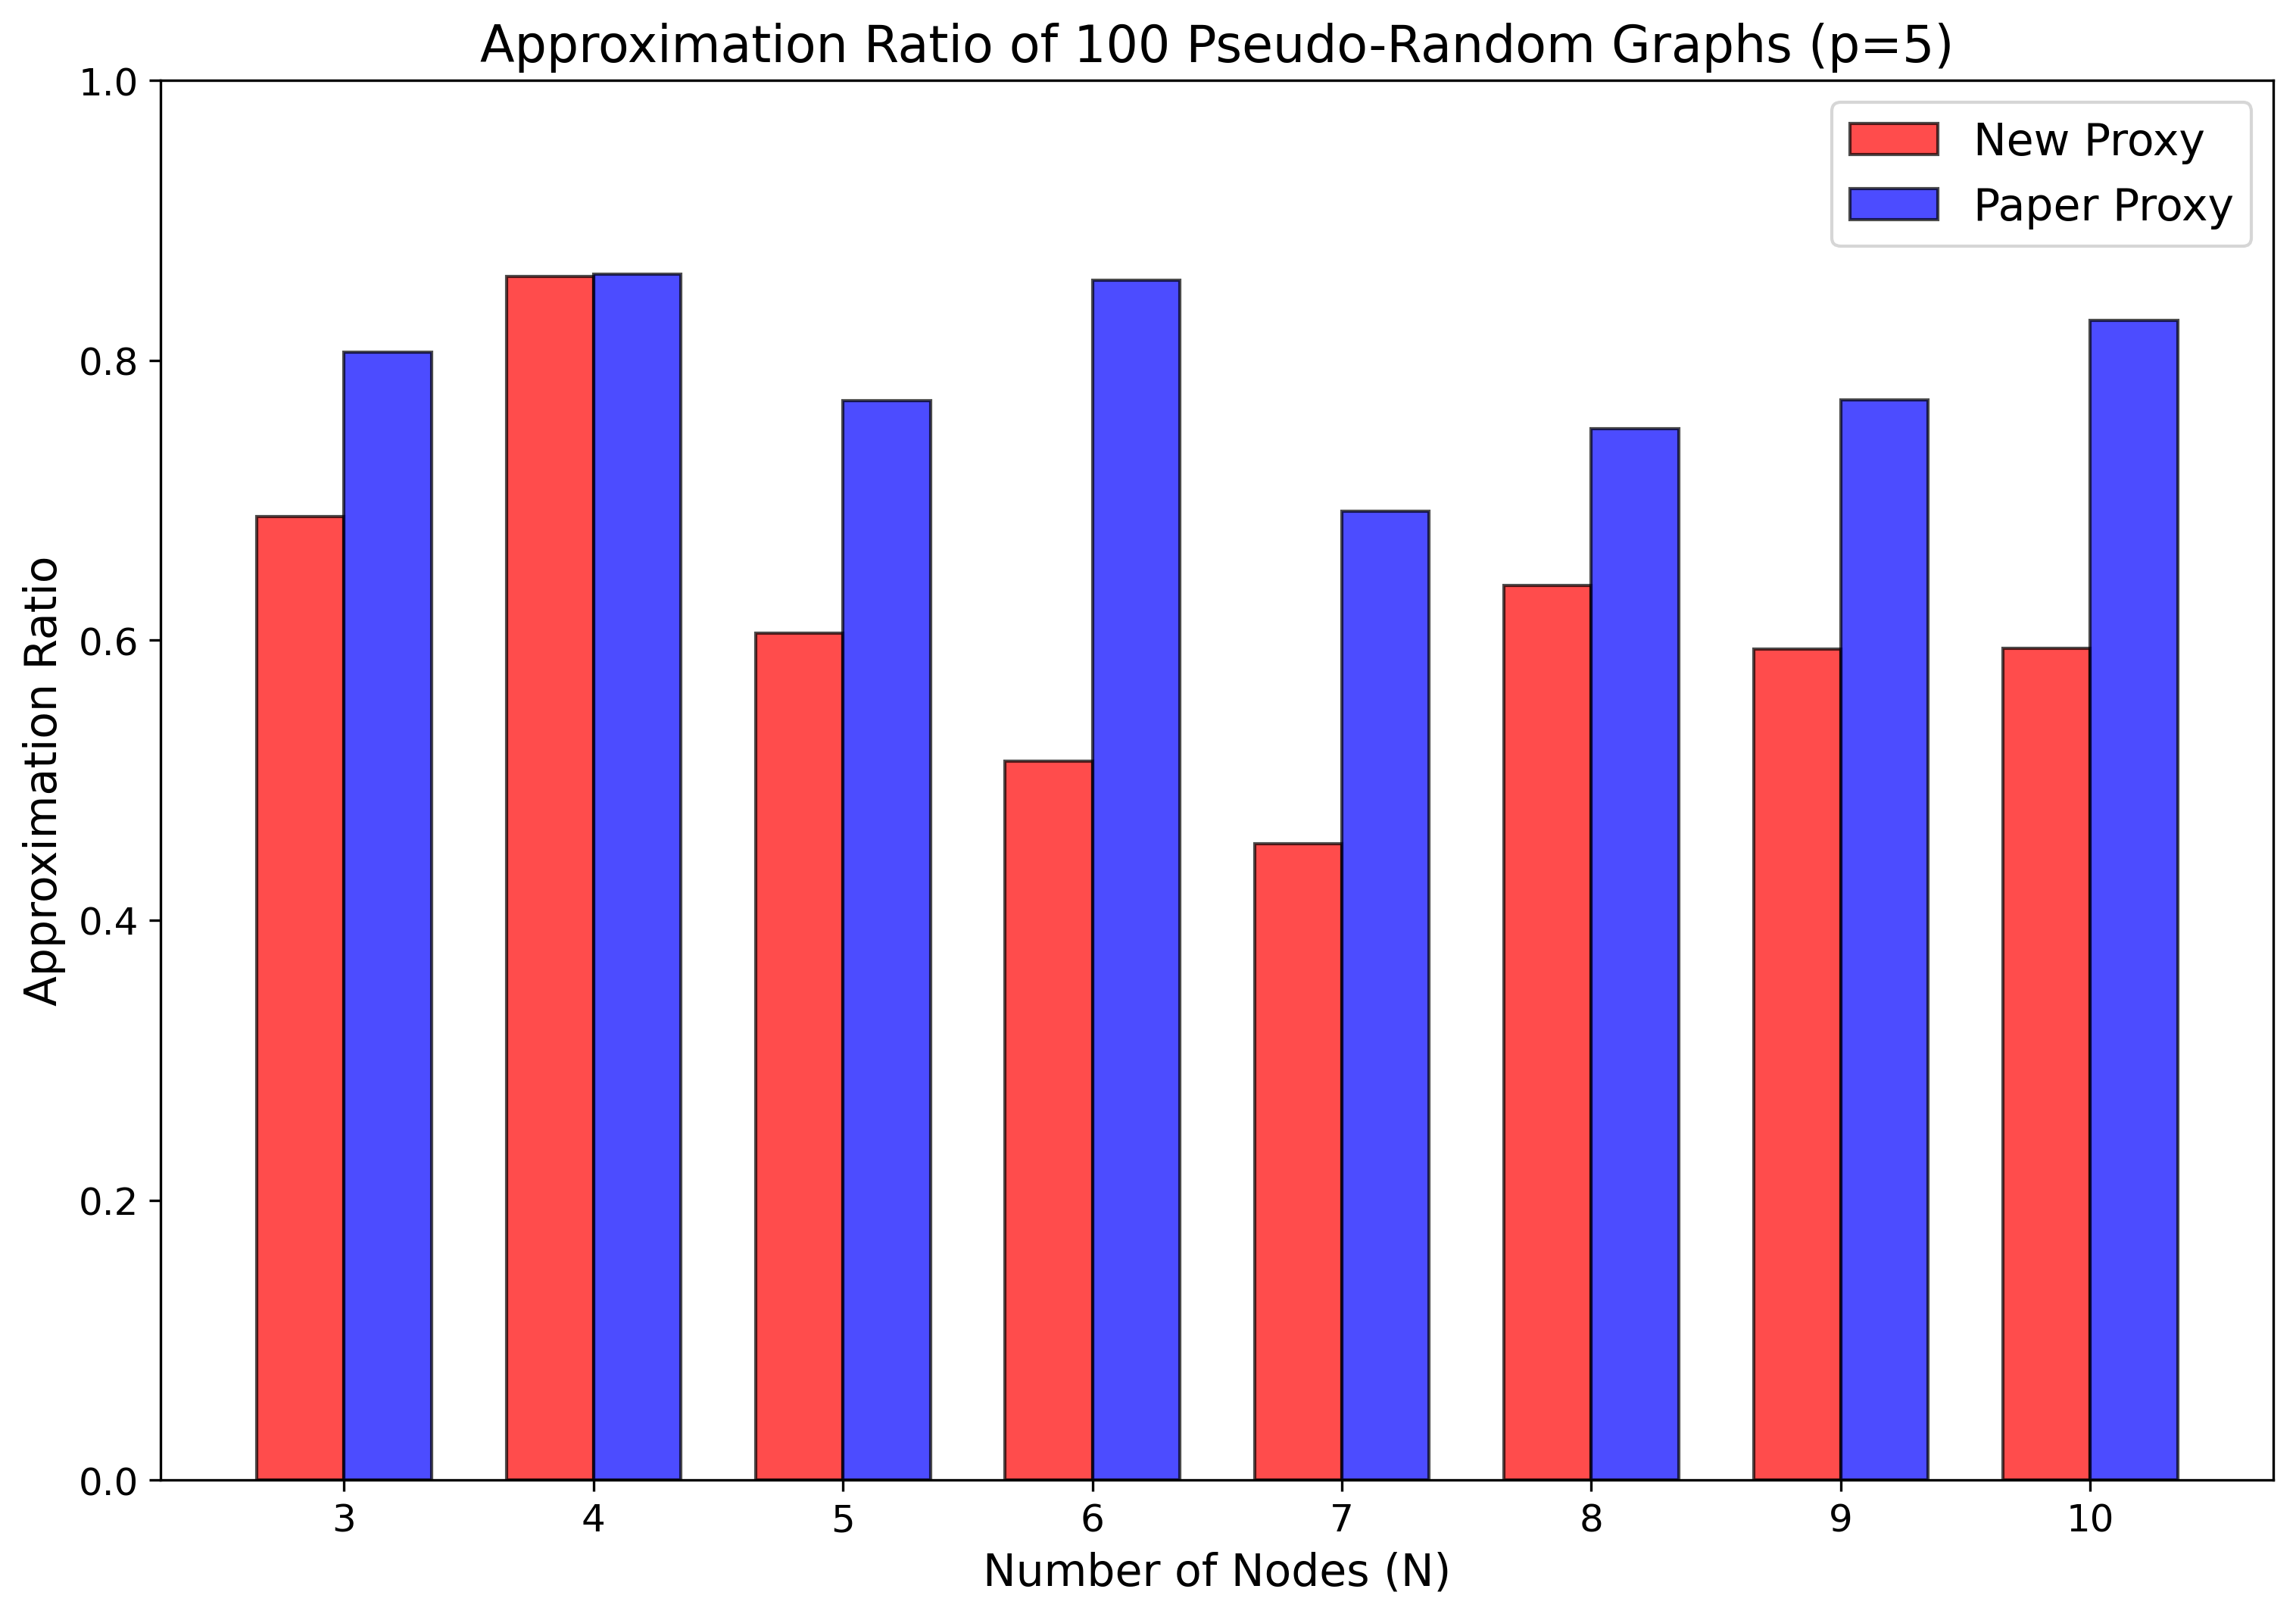

In [18]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qokit.maxcut as mc
from QAOA_simulator import get_expectation, get_simulator
import QAOA_proxy as qp
import QAOA_paper_proxy as qpp
import os  # データ保存に必要

# QAOAの層数
p = 5

# seedの設定
seed = 0

# 各Nの近似比率を格納するリスト（各Nに対して10回の平均を格納）
approx_ratios_new_proxy = []
approx_ratios_paper_proxy = []

def erdos_reyni(num_verts: int, num_edges: int, seed: int | None = None) -> nx.Graph:
    # num_verts: グラフの頂点の数
    # num_edges: グラフのエッジの数
    # seed: 乱数生成のシード（省略可能）

    G = nx.complete_graph(num_verts)

    if (seed is not None):
        np.random.seed(seed)

    edges = np.array(G.edges())

    indices = np.random.choice(a=len(edges), size=len(edges) - num_edges, replace=False)

    for index in indices:
        G.remove_edge(edges[index][0], edges[index][1])

    return G

# 試行回数
T = 100

# 保存先ディレクトリを指定
save_dir = f"data_for_graphs_Approx_Raito_P={p}_T={T}"
os.makedirs(save_dir, exist_ok=True)

# Nを5から10まで変化させて計算
for N in range(3, 11):
    for i in range(T):
        
        approx_ratios_new_proxy_i = []
        approx_ratios_paper_proxy_i = []

        G = nx.erdos_renyi_graph(N, 0.5)
        ising_model = mc.get_maxcut_terms(G)
        sim = get_simulator(N, ising_model)

        init_gamma, init_beta = np.full((2, p), 0.1)

        result = qp.QAOA_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]
        expectation = get_expectation(N, ising_model, gamma, beta)
        max_cost_diagonal = max(sim.get_cost_diagonal())
        approx_ratio = expectation / max_cost_diagonal
        approx_ratios_new_proxy_i.append(approx_ratio)
        np.save(f"{save_dir}/data_for_approx_ratio_new_proxy_N={N}_G{i}.npy", approx_ratio)

        result = qpp.QAOA_paper_proxy_run(G.number_of_edges(), N, p, init_gamma, init_beta)
        gamma = result["gamma"]
        beta = result["beta"]
        expectation = get_expectation(N, ising_model, gamma, beta)
        max_cost_diagonal = max(sim.get_cost_diagonal())
        approx_ratio = expectation / max_cost_diagonal
        approx_ratios_paper_proxy_i.append(approx_ratio)
        np.save(f"{save_dir}/data_for_approx_ratio_paper_proxy_N={N}_G{i}.npy", approx_ratio)

    approx_ratios_new_proxy.append(np.mean(approx_ratios_new_proxy_i))
    approx_ratios_paper_proxy.append(np.mean(approx_ratios_paper_proxy_i))


# 棒グラフの作成
bar_width = 0.35  # バーの幅
index = np.arange(3, 11)  #x軸のインデックス


# グラフのサイズと解像度の設定（figsizeとdpiを調整）
plt.figure(figsize=(12, 8), dpi=300)

# 新しいプロキシの棒グラフ（枠を黒色に設定）
plt.bar(index - bar_width / 2, approx_ratios_new_proxy, bar_width, color='red', alpha=0.7, label='New Proxy', edgecolor='black')

# 論文プロキシの棒グラフ（枠を黒色に設定）
plt.bar(index + bar_width / 2, approx_ratios_paper_proxy, bar_width, color='blue', alpha=0.7, label='Paper Proxy', edgecolor='black')

# グラフの設定
plt.xlabel('Number of Nodes (N)', fontsize=14)  # 横軸のラベル
plt.ylabel('Approximation Ratio', fontsize=14)  # 縦軸のラベル
plt.title(f'Approximation Ratio of {T} Pseudo-Random Graphs (p={p})', fontsize=16)  # 題名
plt.xticks(index, fontsize=12)  # x軸の目盛りのサイズ
plt.yticks(fontsize=12)  # y軸の目盛りのサイズ
plt.ylim([0, 1])  # 縦軸の範囲を設定
plt.legend(prop={'size': 14})

# グラフをファイルとして保存
plt.savefig(f"{save_dir}/Approximation Ratio of {T} Pseudo-Random Graphs (p={p}).png", format='png', bbox_inches='tight')

# グラフの表示
plt.show()